# **MEDICAL IMAGE ANALYSIS USING DEEP LEARNING**
## **KRITIKA CHAUHAN**
## **2015174**  

## **DATASET COLLECTION**

---

In [ ]:
#extracting the dataset from kaggle using kaggle api
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#downloading the dataset
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.14G/1.14G [00:26<00:00, 56.9MB/s]
100% 1.14G/1.14G [00:26<00:00, 45.7MB/s]


In [ ]:
#extracting the contents of zipped file
import zipfile
zf="/content/pneumonia-xray-images.zip"
target_dir="/content/dataset/cnn/pneumonia_revamped"
zfile=zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
#importing some basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_path='/content/dataset/cnn/pneumonia_revamped/train'
test_path='/content/dataset/cnn/pneumonia_revamped/test'
val_path='/content/dataset/cnn/pneumonia_revamped/val'

#batch is the number of training examples utilized in 1 iteration
batch_size=16

#the size of the image that I will be using is 400*400
img_height=400
img_width=400


## **DATA AUGMENTATION**

---



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#creating image data generator from train set
image_gen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,vertical_flip=True)
#creating image data generator from test/validation set
test_data_gen=ImageDataGenerator(rescale=1./255)

## **LOADING THE IMAGES**

---



In [ ]:
#loading the images

train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )
val = test_data_gen.flow_from_directory(
      val_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )


Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


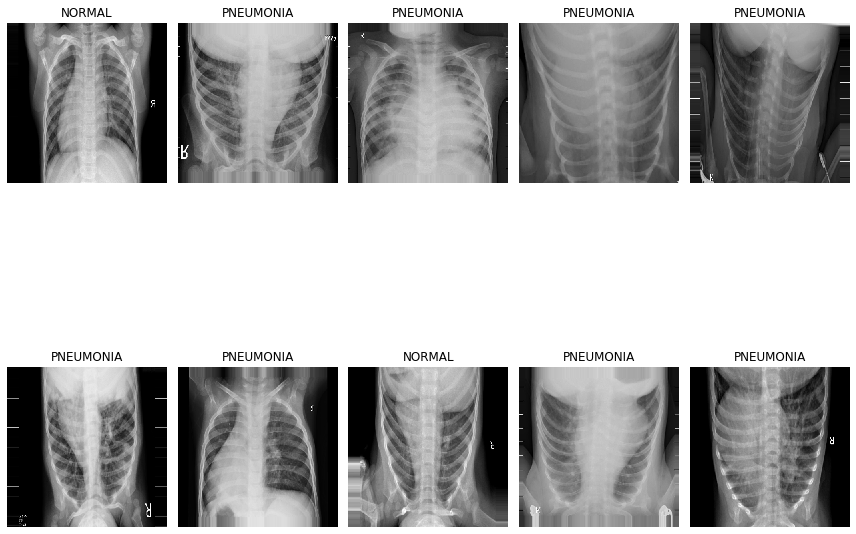

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## **CNN**

---



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
#building a cnn model
model = Sequential()
model.add(Conv2D(32, (3, 3), 
                 activation="relu", 
                 input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3),
                 activation="relu", 
                 input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), 
                 activation="relu", 
                 input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), 
                 activation="relu", 
                 input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), 
                 activation="relu", 
                 input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(activation = 'relu', 
                units = 128))
model.add(Dense(activation = 'relu', 
                units = 64))
model.add(Dense(activation = 'sigmoid', 
                units = 1))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', 
                               classes=np.unique(train.classes), 
                               y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
model.fit(train,epochs=20,validation_data=val,class_weight=cw,callbacks=callbacks_list)

Epoch 1/20
262/262 [==============================] - 117s 408ms/step - loss: 0.5681 - accuracy: 0.6152 - val_loss: 0.2975 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 2/20
262/262 [==============================] - 109s 415ms/step - loss: 0.2767 - accuracy: 0.8848 - val_loss: 0.2460 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 3/20
262/262 [==============================] - 107s 408ms/step - loss: 0.2340 - accuracy: 0.9031 - val_loss: 0.2216 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 4/20
262/262 [==============================] - 107s 409ms/step - loss: 0.2296 - accuracy: 0.9055 - val_loss: 0.1893 - val_accuracy: 0.9404 - lr: 0.0010
Epoch 5/20
262/262 [==============================] - 107s 408ms/step - loss: 0.1863 - accuracy: 0.9191 - val_loss: 0.1758 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 6/20
262/262 [==============================] - 107s 407ms/step - loss: 0.1835 - accuracy: 0.9256 - val_loss: 0.1782 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 7/20
262/262 [==========================

## **EVALUATION**

---



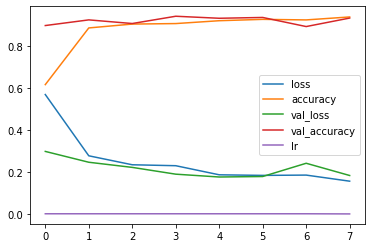

In [ ]:
#evaluating the model
pd.DataFrame(model.history.history).plot()

In [ ]:
test_accuracy=model.evaluate(test)
print('Testing accuracy: ',test_accuracy[1]*100,'%')

39/39 [==============================] - 6s 155ms/step - loss: 0.2845 - accuracy: 0.8974
Testing accuracy:  89.74359035491943 %


In [ ]:
preds=model.predict(test,verbose=1)

39/39 [==============================] - 8s 176ms/step


In [ ]:

predictions=preds.copy()
predictions[predictions<=0.5]=0
predictions[predictions>0.5]=1

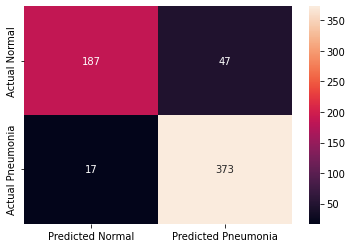

In [ ]:
#confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
conf_mat=pd.DataFrame(data=confusion_matrix(test.classes, 
                                            predictions, 
                                            labels=[0,1]),
                                            index=["Actual Normal","Actual Pneumonia"],
                                            columns=["Predicted Normal","Predicted Pneumonia"])

import seaborn as sns
sns.heatmap(conf_mat,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,
                            y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.92      0.80      0.85       234
   PNEUMONIA       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



(624, 400, 400, 1)
(624,)


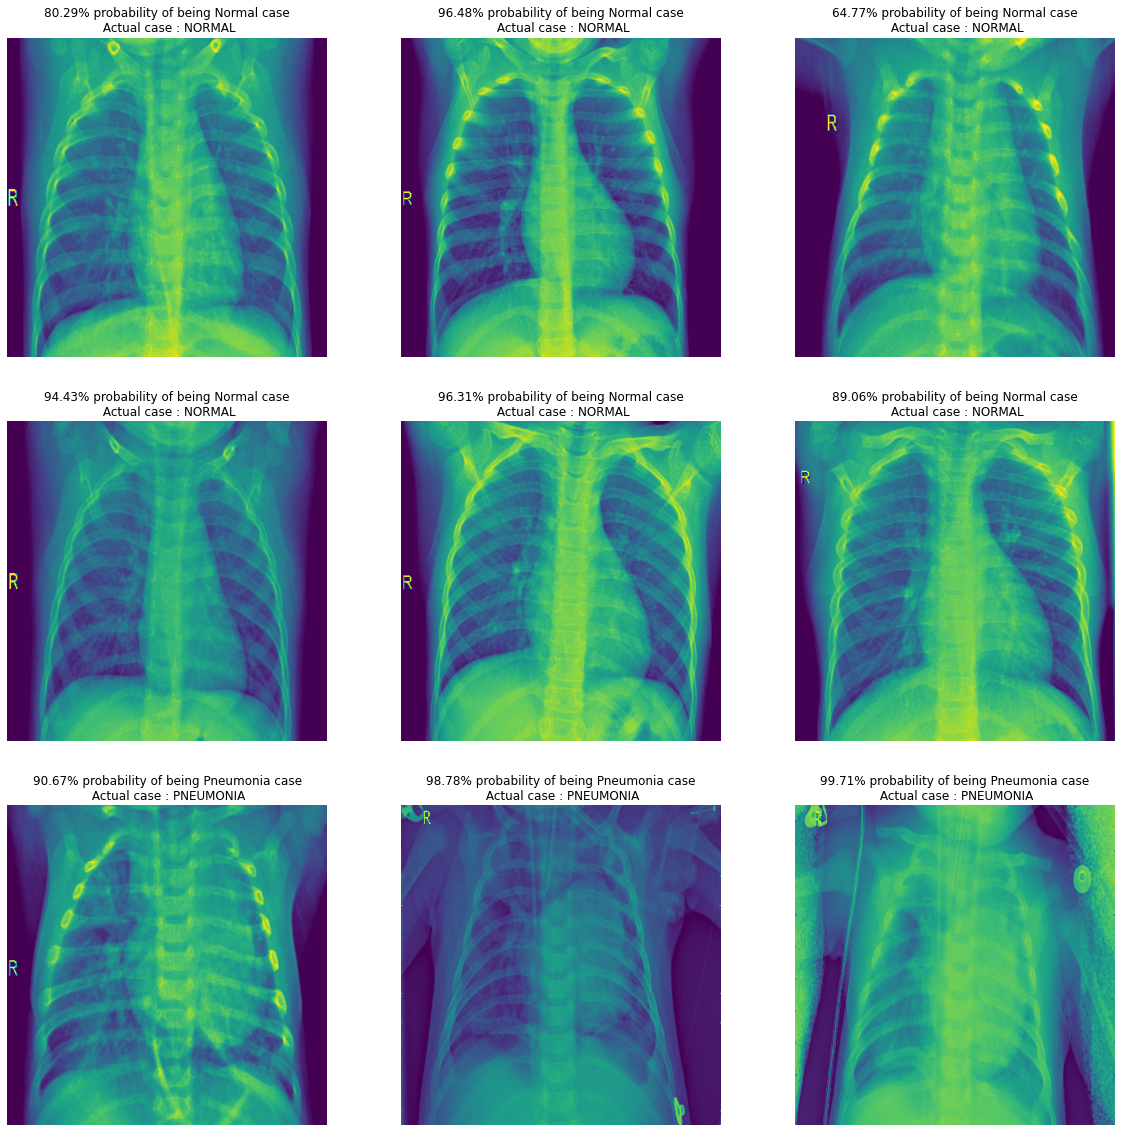

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()